# Lab 4: Clustering and Linear Regression

### Due September 21st, 2022 11:59 PM

**Logistics and Lab Submission**

See the course website. Remember that all labs count equally, despite the labs being graded from a different number of total points.

### What You Will Need to Know For This Lab

* K-means clustering
* Vector Quantization
* Nearest Neighbors Classification
* Linear Regression

The submission procedure is provided below:
- You will be provided with a template Python script (main.py) for this lab where you need to implement the provided functions as needed for each question. Follow the instructions provided in this Jupyter Notebook (.ipynb) to implement the required functions. **Do not change the file name or the function headers!**
- Upload only your Python script (.py file) on Gradescope. Don't upload your datasets or Jupyter Notebook (.ipynb file).
- Your grades and feedbacks will appear on Gradescope. The grading for the programming questions is automated using Gradescope autograder, no partial credits are given. Therefore, if you wish, you will have a chance to re-submit your code **within 72 hours** of receiving your first grade for this lab, only if you have *reasonable* submissions before the deadline (i.e. not an empty script).
- You can submit for any times you want before the deadline. After the deadline, you will see a re-submission assignment open on Gradescope, and you can still submit multiple times to that re-submission assignment within 72 hours. If you re-submit after the deadline, the final grade for the programming part of this lab will be calculated as max{first_grade, .4 \* first_grade + .6 \* .9 \* re-submission_grade}.
- This lab also has Multiple Choice Questions (MCQs) that are needed to be completed on Gradescope **within the deadline**.

There are some problems which have short answer questions. They are not graded, but we are free to discuss answers to these problems. **Multiple Choice Questions (MCQs) will be graded on Gradescope!**

### Preamble (don't change this)

In [1]:
%pylab inline
import numpy as np
from sklearn import neighbors
from numpy import genfromtxt
import scipy.spatial.distance as dist
from sklearn.cluster import KMeans
from PIL import Image
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
%run main.py
q1 = Question1()
q2 = Question2()
q3 = Question3()
q4 = Question4()

### Problem 1: Selecting the number of clusters (20 points)

**Part 1:** In function `kMeans`, you should implement the $K$-means clustering algorithm.

You will be given as input:
* A $(N,d)$ `numpy.ndarray` of unlabeled data (with each row as a feature vector), data
* A scalar $K$ which indicates the number of clusters
* A scalar representing the number of iterations, *niter* (this is your stopping criterion/criterion for convergence)

Your output will be a tuple consisting of a vector of length $N$ containing which cluster ($0,\ldots,K-1$) a feature vector is in and a $(K,d)$ matrix with the rows containing the cluster centers.

Your code should alternatingly re-fit the cluster centers (randomly initialize in the first round) and find the corresponding labels. The above alternating process should take *niter* iterations. For grading purposes, you are also given a random seed. Do NOT change it!

Do not use scikit-learn or similar for implement K-means clustering. You may use `scipy.spatial.distance.cdist` to calculate distances. Initialize the centers randomly without replacement with points from the data set. To be consistent with the autograder, you should use `np.random.choice` to randomly choose $K$ points for initialization. <b>(10 points)</b>

**Part 2:** The K-means clustering problem tries to minimize the following quantity by selecting $\{z_i\}_{i=1}^N$ and $\{\mu_k\}_{k=1}^K$:
$$J_K(\{z_i\}_{i=1}^N ,\{\mu_k\}_{k=1}^K)=\sum_{i=1}^N \lVert \mathbf{x}_i - \mathbf{\mu}_{z_i} \rVert^2$$
where $\mathbf{\mu}_{z_i}$ is the center of the cluster to which $\mathbf{x}_i$ is assigned.

One visual heuristic to choose the number of clusters from the data (where the number of clusters is not known a priori) is to estimate the optimal value of $J_K(\{z_i\}_{i=1}^N ,\{\mu_k\}_{k=1}^K)$, $J^*(K)$ , for different values of $K$ and look for **an "elbow" or "knee"** in the curve of $J^*$ versus $K$ and choose that value of $K$. 

In function `calculateJ`, you should run $K$-means for each $K=2,\ldots,10$ and calculate $J_K(\{z_i\}_{i=1}^N ,\{\mu_k\}_{k=1}^K)$ for the clustering given by $K$-means. Note that in practice, you can have multiple runs for each $K$ value, and take the minimum $J_K$ value (for each $K$) to get the plot.

For an attempt to formalize this heuristic, see Tibshirani, Robert, Guenther Walther, and Trevor Hastie. "Estimating the number of clusters in a data set via the gap statistic." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 63.2 (2001): 411-423. Sometimes, an elbow does not exist in the curve or there are multiple elbows or the $K$ value of an elbow cannot be unambiguously identified. Further material can be found on <a href="http://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method">Wikipedia</a> as well.  

Note: Your code should be relatively quick -- a few minutes, at worst. <b>(10 points)</b>

[228.54819511 166.09416049 132.57078277 124.89624852 115.37766626
 109.83713888 105.50066194 100.50127634  93.21001557]


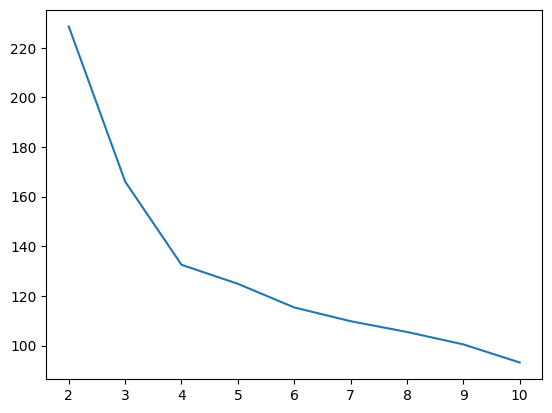

In [3]:
# Load up some data, which we will store in a variable called problem1
q1 = Question1()
data_p1 = genfromtxt('problem1.csv', delimiter=',')
err = q1.calculateJ(data_p1,q1.kMeans)
plot(range(2,11),err)

Using the value of $K$ you determined from the elbow, the following code performs K-means clustering on the data. It uses a scatter plot with the colors given by the labels.

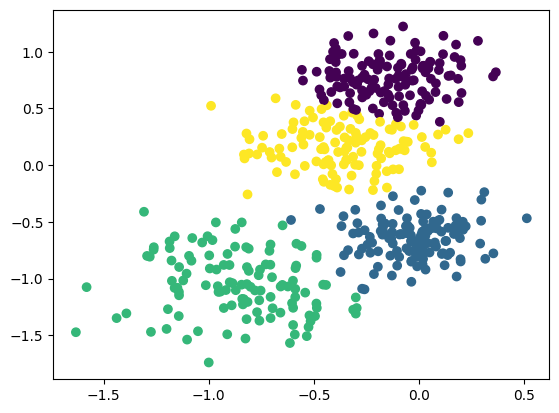

In [75]:
K = 4# Put your K value here
lk,ck = q1.kMeans(data_p1,K,100)
scatter(data_p1[:,0], data_p1[:,1], c=lk)

### Problem 2: Vector Quantization (30 points)

In this problem, you will implement vector quantization. You will use `sklearn.cluster.KMeans` for the K-means implementation and use *k-means++* as the initialization method. See Section 4.2.1 in the notes for details. 

**Part 1:** Write function `trainVQ` to generate a codebook for vector quantization. You will be given inputs:
* A $(N,M)$ `numpy.ndarray` representing a greyscale image, called *image*. (Note that in practice, if we want to generate our codebook from multiple images, we can concatenate the images before running them through this function.)
* A scalar $B$, for which you will use $B \times B$ blocks for vector quantization. You may assume $N$ and $M$ are divisible by $B$.
* A scalar $K$, which is the size of your codebook

You will return:
* The codebook as a $(K,B^2)$ `numpy.ndarray`.

**For grading purposes only:** Please flatten any matrix in *row-major* order. Use `numpy.flatten` to flatten your matrix. <b>(10 points)</b>

**Part 2:** Write function `compressImg` which compresses an image against a given codebook. You will be given inputs:
* A $(N,M)$ `numpy.ndarray` representing a greyscale image, called image. You may assume $N$ and $M$ are divisible by $B$.
* A $(K,B^2)$ codebook called *codebook*
* Block width $B$

You will return:
* A $(N/B,M/B)$ `numpy.ndarray` consisting of the indices in the codebook used to approximate the image. 

You can use the nearest neighbor classifier from scikit-learn if you want (though it is not necessary) to map blocks to their nearest codeword. <b>(10 points)</b>

**Part 3:** Write function `decompressImg` to reconstruct an image from its codebook. You will be given inputs:
* A $(N/B,M/B)$ `numpy.ndarray` containing the indices of the codebook for each block called indices
* A $(K,B^2)$ `numpy.ndarray` called *codebook*
* Block width $B$

You will return a $(N,M)$ `numpy.ndarray` representing the image. <b>(10 points)</b>

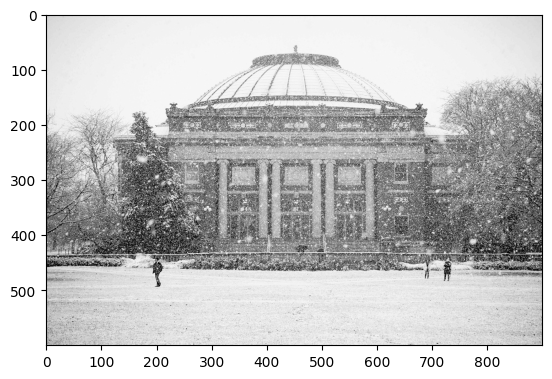

In [76]:
# The provided image is stored in image
image = np.asarray(Image.open("mrtb.jpg").convert("L"))
imshow(image, cmap = cm.Greys_r)

The following code runs your vector quantizer with $5 \times 5$ blocks on the provided image with codebook sizes $K=2,5,10,20,50,100,200$ (i.e. it generates codebooks from this image of those sizes, compresses the image using those codebooks and reconstructs the images). It also displays (for each K) the reconstructed images.

<Figure size 640x480 with 0 Axes>

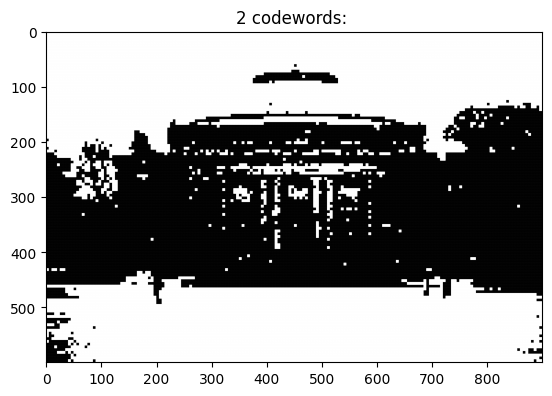

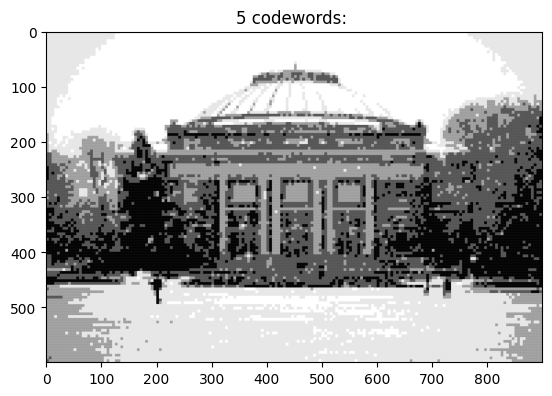

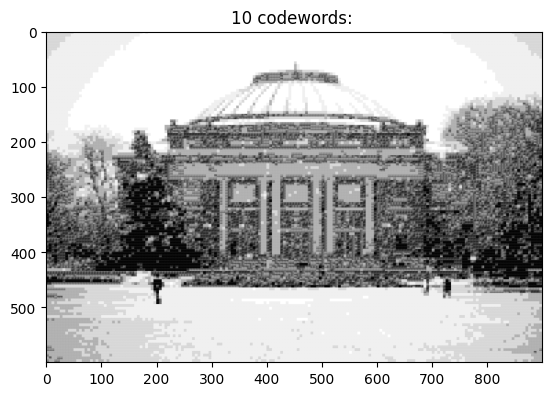

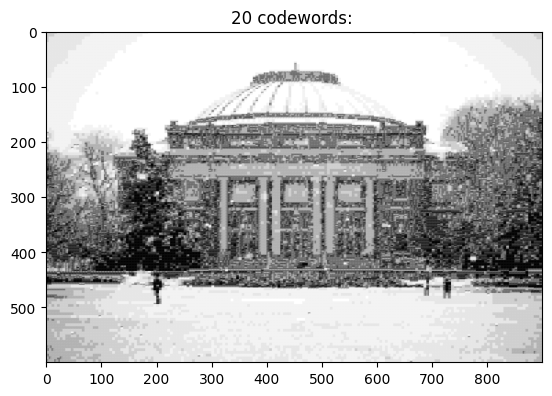

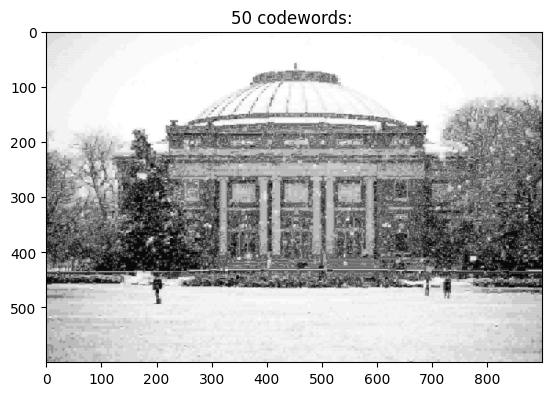

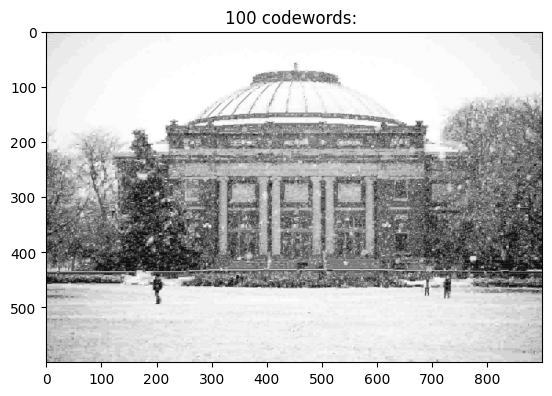

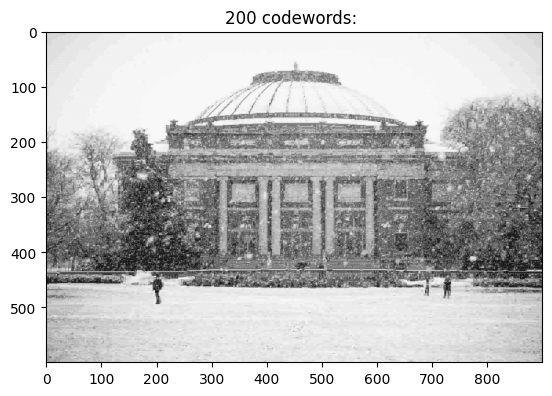

In [77]:
%run main.py
q2 = Question2()
B = 5
for K in [2,5,10,20,50,100,200]:
    codebook,_ = q2.trainVQ(image,B,K)
    cmpimg = q2.compressImg(image,codebook,B)
    dcpimg = q2.decompressImg(cmpimg,codebook,B)
    figure()
    title("{} codewords: ".format(K))
    imshow(dcpimg, cmap = cm.Greys_r)

**The following question is for you think about to further your understanding of these classifiers. These will not be graded. You could discuss these with other students or the TAs during the office hours.**

Which code book would you pick? Why? Make sure to take into account the bits per pixel used by the compressor.

Note the number of bits per pixel can be approximated as $\frac{\log_2 K}{25}$ and the codebook takes approximately $200K$ bits (assuming each pixel is stored as 8 bits). Some good ideas on quantitative arguments for codebook size can be found in Gonzalez & Woods, Digital Image Processing 3e or Gersho & Gray, Signal Compression & Vector Quantization. It is not necessary to look at these references for quantitative arguments, though.

The image used is under fair use from [Daily Illini](https://dailyillini.com/special-sections/international-student-guide/2018/08/15/how-to-dress-for-the-midwestern-weather/).

### Problem 3: Using K-means to Accelerate Nearest Neighbors (20 points)

In this problem, you will use K-means clustering to accelerate nearest neighbors, as outlined in the notes (Algorithm 7). Use `sklearn.neighbors.KNeighborsClassifier` for nearest neighbor classification and `sklearn.cluster.KMeans` for the K-means implementation with *k-means++* as the initialization method.

You will write a function to generate prototypes from labeled data. It will have input:
* Training features as $(N,d)$ `numpy.ndarray` called *traindata*
* Training labels as a length $N$ vector called *trainlabels*
* $K\_list$, a list of the number of prototypes under each class

You will return a tuple of two lists:
* A length $len(K\_list)$ list containing the prototypes selected. The $j$-th element in the list is a ($K\_list[j] * \text{num_classes}, d)$ `numpy.ndarray`, representing the prototypes selected if using $K\_list[j]$ prototypes under each class. You should keep the order as in the given $K\_list$.
* A length $len(K\_list)$ list containing the prototypes selected. The $j$-th element in the list is a ($K\_list[j] * \text{num_classes},)$ `numpy.array`, representing the corresponding labels if using $K\_list[j]$ prototypes under each class. You should keep the order as in the given $K\_list$.

You may assume there are at least $\min(K\_list)$ examples under each class. `set(trainlabels)` or `numpy.unique` will give you the set of labels. <b>(10 points)</b>

Next, train a nearest neighbor classifier (i.e. 1-NN)  according to a given list of K prototypes per class for the digits data set from Lab 2. Return the validation error for each K value (in the same order as the given K_list). <b>(10 points)</b>


Note that this data set is generated from zip code digits from US mail, and the US Postal Service processes <a href="https://about.usps.com/who-we-are/postal-facts/one-day-by-the-numbers.htm">hundreds of millions of pieces of mail</a> a day, so a small improvement in error can lead to tremendous savings in terms of mis-routed packages (which cost a lot of money and time to re-transport).

In [78]:
# Load the digits data set

#Read in the Training Data
traindata_tmp= genfromtxt('zip.train', delimiter=' ')
#The training labels are stored in "trainlabels", training features in "traindata"
trainlabels=traindata_tmp[:,0]
traindata=traindata_tmp[:,1:]


#Read in the Validation Data
valdata_tmp= genfromtxt('zip.val', delimiter=' ')
#The validation labels are stored in "vallabels", validation features in "valdata"
vallabels=valdata_tmp[:,0]
valdata=valdata_tmp[:,1:]

In [79]:
%run main.py
q3 = Question3()
K_list = [1,10,50,100,200]
proto_dat_list, proto_lab_list = q3.generatePrototypes(traindata,trainlabels,K_list)
protoerr = q3.protoValError(proto_dat_list,proto_lab_list,valdata,vallabels)
for k,e in zip(K_list,protoerr):
    print("Validation Error for %s prototypes: %s" % (k, e))

AttributeError: 'list' object has no attribute 'astype'

<Figure size 640x480 with 0 Axes>

Recall that the validation error without using prototypes is around 0.056.

### Problem 4: Linear Regression (30 points)

In this problem, you will do model selection for linear regression using Ordinary Least Squares, Ridge Regression and the LASSO.

The dataset you will use has 8 features:

    lcavol - log cancer volume
    lcaweight - log prostate weight
    age
    lbph - log of amount of benign prostatic hyperplasia
    svi - seminal vesicle invasion
    lcp - log capsular penetration
    gleason - Gleason score
    pgg45 - percent of Gleason scores 4 or 5

and you will predict the level of a prostate-specific antigen. The data set was collected from a set of men about to receive a radical prostatectomy. More details are given in Section 3.2.1 in Elements of Statistical Learning 2e by Hastie et al.

In [ ]:
# Load the data
trainp= genfromtxt('trainp.csv', delimiter=',')

# Training data: 
trainfeat=trainp[:,:-1] #Training features (rows are feature vectors)
trainresp=trainp[:,-1] #Training responses

valp= genfromtxt('valp.csv',delimiter=',')
# Validation data:
valfeat=valp[:,:-1] #Validation Features (rows are feature vectors)
valresp=valp[:,-1] #Validation Response

# Standardize and center the features
ftsclr=StandardScaler()
trainfeat = ftsclr.fit_transform(trainfeat)
valfeat= ftsclr.transform(valfeat)
# and the responses (note that the example in the notes has centered but not 
#                    standardized responses, so your numbers won't match up)
rsclr=StandardScaler()
trainresp = (rsclr.fit_transform(trainresp.reshape(-1,1))).reshape(-1)
valresp= (rsclr.transform(valresp.reshape(-1,1))).reshape(-1)
%run main.py
q4 = Question4()

**Part 1:** Since we centered the responses, we can begin with a **benchmark (or baseline)** model: *Always predict the response as zero*. (If not centered, this would predict the mean response on the training data.) In function `benchmarkRSS`, calculate the validation RSS for this model. **(5 points)**

If another model does worse than this, it is a sign that something is amiss.

Note: The RSS on a data set with $V$ samples is given by $\frac{1}{V} \lVert \mathbf{y} - \hat{\mathbf{y}} \rVert^2$ where $\mathbf{y}$ is a vector of the responses, and $\hat{\mathbf{y}}$ is the predicted responses on the data.

In [ ]:
print("The benchmark validation RSS is:", q4.benchmarkRSS(trainfeat,trainresp,valfeat,valresp))

The benchmark validation RSS is: 0.733852091912677


**Part 2:** Next, you will try (Ordinary) Least Squares. In function `OLSRSS`, use `sklearn.linear_model.LinearRegression` with the default options and calculate the validation RSS. <b>(5 points)</b>

*Note: The .score() method returns an [R^2 value](https://en.wikipedia.org/wiki/Coefficient_of_determination), not the RSS, so you shouldn't use it anywhere in this problem.*

In [ ]:
print("The OLS validation RSS is:", q4.OLSRSS(trainfeat,trainresp,valfeat,valresp))

The OLS validation RSS is: 0.36230709903819774


**Part 3:** Then, in function `RidgeRSS`, you will apply ridge regression with `sklearn.linear_model.Ridge`. In the funciton, sweep the regularization/tuning parameter $\alpha=0,\ldots,100$ with 1000 equally spaced values. 

The following code makes a plot of the RSS on the validation set versus $\alpha$. What is the minimizing $\alpha$, corresponding coefficients and validation error?

*Note: Larger values of $\alpha$ shrink the weights in the model more. $\alpha=0$ corresponds to the LS solution.* <b>(10 points)</b>

The minimizing alpha is: 12.312312312312313
The best coefficients are:
[ 0.42874536  0.22631082 -0.06455834  0.15539095  0.21579184 -0.05436134
  0.02588654  0.13447399]
The best validation RSS is: 0.33848533278161635


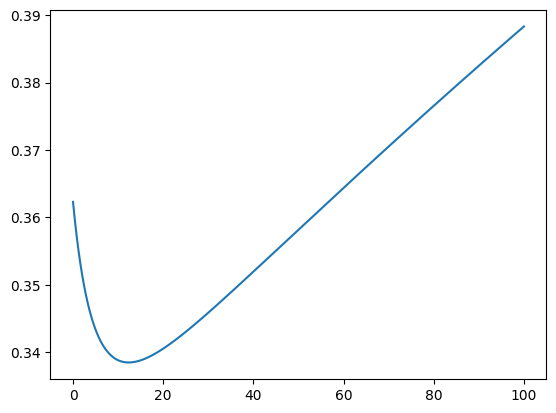

In [ ]:
rss_array, best_a, best_rss, coef = q4.RidgeRSS(trainfeat,trainresp,valfeat,valresp)
print("The minimizing alpha is: %s" % best_a)
print("The best coefficients are:")
print(coef)
print("The best validation RSS is: %s" % best_rss)
a = np.linspace(0,100,1000)
plot(a,rss_array)

**Part 4:** Now, you will apply the LASSO with `sklearn.linear_model.Lasso`. In function `LassoRSS`, sweep the tuning/regularization parameter $\alpha=0,\ldots,1$ with 1000 equally spaced values. 

The following code makes makes a plot of the RSS on the validation set versus $\alpha$. What is the minimizing $\alpha$, corresponding coefficients and validation error?

*Note: Larger values of $\alpha$ lead to sparser solutions (i.e. less features used in the model), with a sufficiently large value of $\alpha$ leading to a constant prediction. Small values of $\alpha$ are closer to the LS solution, with $\alpha=0$ being the LS solution.* <b>(10 points)</b>

The minimizing alpha is: 0.09299999999999997
The best coefficients are:
[ 0.47490839  0.18706547 -0.          0.07857742  0.13591787  0.
  0.          0.04868055]
The best validation RSS is: 0.31426491652065836


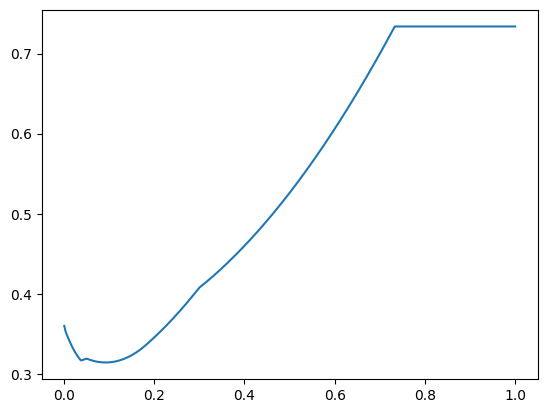

In [ ]:
rss_array, best_a, best_rss, coef = q4.LassoRSS(trainfeat,trainresp,valfeat,valresp)
print("The minimizing alpha is: %s" % best_a)
print("The best coefficients are:")
print(coef)
print("The best validation RSS is: %s" % best_rss)
a = np.linspace(1,0,1000,endpoint=False)[::-1]
plot(a,rss_array)

## And this concludes Lab 4! Congratulations!